In [1]:
img_rows = 224
img_cols = 224
color_type = 1
batch_size=16
epochs=16
cache = 'e:/kaggle_imgs/cache/StateFarm'
img_path="E:/kaggle_imgs/Statefarm/Data/imgs/train"

import os
import shutil
if not os.path.exists(cache):
    os.mkdir(cache)
saved_path="{}/saved_models".format(cache)
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
filepath='{}/weights_best_normal_model_0508.hdf5'.format(saved_path)

In [2]:
# import module
from PIL import Image as IM
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from time import time
from pickle import load, dump
from pandas import DataFrame, read_csv
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import log_loss
from keras.models import Sequential, Model
from keras.layers import Dropout,Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def get_image(path, img_rows, img_cols, color_type):
    img = IM.open(path)
    img = img.resize((img_rows,img_cols))
    img = np.array(img)
    img = rgb2gray(img)
    return img

def load_train(img_rows, img_cols, color_type, paths):
    images = []
    labels = []
    for i in range(10):
        start = time()
        files = glob(paths[i])
        for file in files:
            images.append(get_image(file, img_rows, img_cols, color_type))
            labels.append(i)
        print('directory {} loaded in {:.2f} seconds, count:{}'.format(paths[i], time() - start, len(files)))
    return images, labels

def normalized_train(img_rows, img_cols, color_type,image_path):
    path=[]
    for i in range(10):
        path.append('{}/c{}/*.jpg'.format(img_path,i))
    print(path)
    images, labels = load_train(img_rows, img_cols, color_type,path)
    labels = np_utils.to_categorical(labels, 10)
    return images,labels

def load_test(img_rows, img_cols, color_type):
    start = time()
    images = []
    names = []
    img_ap = images.append
    nam_ap = names.append
    files = glob('../input/state-farm-distracted-driver-detection/imgs/test/*.jpg')
    print(len(files))
    for file in files:
        img_ap(get_image(file, img_rows, img_cols, color_type))
        nam_ap(os.path.basename(file))
    return images, names

def normalized_test(img_rows, img_cols, color_type):
    images, names = load_test(img_rows, img_cols, color_type)
    images = np.array(images, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    return images, names

In [4]:
# load train data
if os.path.exists('train_data.pickle'):
    try:
        print('loading train data from pickle', flush=True)
        with open('train_data.pickle', 'rb') as f:
            train_images, valid_images, train_labels, valid_labels = load(f)
        print('complete!', flush=True)
    except EOFError:
        print('EOFError raised.', flush=True)
        print('loading train data...', flush=True)
        os.system('rm -f ../working/train_data.pickle')
        train_images, valid_images, train_labels, valid_labels = normalized_train(img_rows, img_cols, color_type)
        print('complete!', flush=True)
        print('pickling train data...', flush=True)
        with open('train_data.pickle', 'wb') as f:
            dump((train_images, valid_images, train_labels, valid_labels), f)
        print('complete!', flush=True)
else:
    print('loading train data...', flush=True)
    trains,labels=normalized_train(img_rows, img_cols, color_type,img_path)
    train_images, valid_images, train_labels, valid_labels = train_test_split(trains, labels, test_size=0.2)
    train_images = np.array(train_images, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    valid_images = np.array(valid_images, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    print('complete!', flush=True)
    print('pickling train data...', flush=True)
    with open('train_data.pickle', 'wb') as f:
        dump((train_images, valid_images, train_labels, valid_labels), f)
        
    


loading train data from pickle
complete!


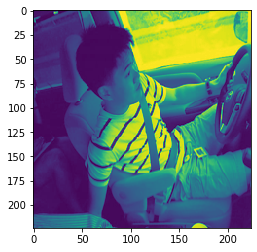

In [5]:
train_labels.sum(axis=0),valid_labels.sum(axis=0)
train_images=train_images/255.
valid_images=valid_images/255.
plt.imshow(train_images[100].reshape(224,224))

In [6]:
# stats
train_size = len(train_images)
valid_size = len(valid_images)
test_size = len(glob('data/imgs/test/*.jpg'))
print('stats:', flush=True)
print('{} train images'.format(train_size), flush=True)
print('{} validation images'.format(valid_size), flush=True)
print('{} test images'.format(test_size), flush=True)
print('train_images.shape = {}'.format(train_images.shape), flush=True)
print('train_labels.shape = {}'.format(train_labels.shape), flush=True)
print('valid_images.shape = {}'.format(valid_images.shape), flush=True)
print('valid_labels.shape = {}'.format(valid_labels.shape), flush=True)

stats:
17939 train images
4485 validation images
0 test images
train_images.shape = (17939, 224, 224, 1)
train_labels.shape = (17939, 10)
valid_images.shape = (4485, 224, 224, 1)
valid_labels.shape = (4485, 10)


In [8]:
checkpoint = ModelCheckpoint(filepath=filepath, 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_acc",
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)
callbacks = [checkpoint, es,learning_rate_reduction]

In [9]:
def get_model():
    input_layer = Input((img_rows, img_cols, 1))
    x = Conv2D(32, (3, 3))(input_layer)
    x = Conv2D(32, (3, 3))(x)
    x = Conv2D(32, (3, 3))(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Conv2D(64, (3, 3))(x)
    x = Conv2D(64, (3, 3))(x)
    x = Conv2D(64, (3, 3))(x)
    x = MaxPooling2D(pool_size=4)(x)
    x = Conv2D(128, (3, 3))(x)
    x = Conv2D(128, (3, 3))(x)
    x = Conv2D(128, (3, 3))(x)
    x = MaxPooling2D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs = input_layer, outputs = predictions)
    return model
model = get_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 105, 105, 64)      3692

In [10]:
# data augmentation configuration
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images)

In [11]:
training_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
validation_data = (valid_images,valid_labels)

In [12]:
model.load_weights(filepath)
history = model.fit_generator(
    training_generator,
    epochs = epochs, 
    validation_data = validation_data,
    verbose = 1,
    steps_per_epoch = train_images.shape[0] // batch_size,
    callbacks=callbacks,
    validation_steps = valid_images.shape[0] // batch_size)

Epoch 1/16
1121/1121 [==============================] - 212s 189ms/step - loss: 1.9584 - accuracy: 0.3222 - val_loss: 0.7416 - val_accuracy: 0.7683

Epoch 00001: val_loss improved from inf to 0.74165, saving model to e:/kaggle_imgs/cache/StateFarm/saved_models/weights_best.hdf5
Epoch 2/16
   1/1121 [..............................] - ETA: 3:04 - loss: 0.4538 - accuracy: 0.8750

C:\Users\ipofri-desktop\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1121/1121 [==============================] - 207s 185ms/step - loss: 0.8241 - accuracy: 0.7239 - val_loss: 0.4139 - val_accuracy: 0.8629

Epoch 00002: val_loss improved from 0.74165 to 0.41389, saving model to e:/kaggle_imgs/cache/StateFarm/saved_models/weights_best.hdf5
Epoch 3/16
1121/1121 [==============================] - 207s 185ms/step - loss: 0.5685 - accuracy: 0.8171 - val_loss: 0.3367 - val_accuracy: 0.8934

Epoch 00003: val_loss improved from 0.41389 to 0.33672, saving model to e:/kaggle_imgs/cache/StateFarm/saved_models/weights_best.hdf5
Epoch 4/16
1121/1121 [==============================] - 207s 185ms/step - loss: 0.4717 - accuracy: 0.8519 - val_loss: 0.2884 - val_accuracy: 0.9226

Epoch 00004: val_loss improved from 0.33672 to 0.28842, saving model to e:/kaggle_imgs/cache/StateFarm/saved_models/weights_best.hdf5
Epoch 5/16
 425/1121 [==========>...................] - ETA: 1:58 - loss: 0.4318 - accuracy: 0.8629

InternalError: GPU sync failed

In [ ]:
# plot history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')